# ResNet Implementation with TensorFlow

## Download CIFAR10

In [1]:
import numpy as np
from tensorflow.keras.datasets.cifar10 import load_data

In [2]:
(trainX, trainY), (testX, testY) = load_data()

In [3]:
print(trainX.shape)
print(testX.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
print(trainY.shape)
print(testY.shape)

(50000, 1)
(10000, 1)


In [5]:
train_num = int(len(trainX)*0.9)
valid_num = len(trainX) - train_num

In [6]:
validX = trainX[-valid_num:]
validY = trainY[-valid_num:]

trainX = trainX[:train_num]
trainY = trainY[:train_num]

## Construct Model

In [7]:
input_shape = trainX.shape[1:]

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, MaxPool2D, Dense
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
# Basic Block

def make_residual(num_filters, stride):
    def f(x):
        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=stride, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=1, padding='same',
                   use_bias=False, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        
        return x
    
    return f

In [10]:
channels=[16,16,32,64,128]

In [11]:
input_shape

(32, 32, 3)

In [12]:
input_tensor=Input(input_shape)

x = Conv2D(filters=channels[0], kernel_size=(7,7), padding='same', activation=None, use_bias=False, kernel_initializer='he_uniform')(input_tensor)
x = BatchNormalization()(x)
x = relu(x)

# Block 1
x = add([make_residual(channels[0], 1)(x), x])

# Block 2
y = make_residual(channels[1], 2)(x)
z = Conv2D(filters=channels[1], kernel_size=(1,1), strides=2, padding='same', activation=None)(x)
x = add([y,z])

# Block 3
y = make_residual(channels[2], 1)(x)
z = Conv2D(filters=channels[2], kernel_size=(1,1), strides=1, padding='same', activation=None)(x)
x = add([y,z])

# Block 4
y = make_residual(channels[3], 2)(x)
z = Conv2D(filters=channels[3], kernel_size=(1,1), strides=2, padding='same', activation=None)(x)
x = add([y,z])

# Block 5
y = make_residual(channels[4], 2)(x)
z = Conv2D(filters=channels[4], kernel_size=(1,1), strides=2, padding='same', activation=None)(x)
x = add([y,z])

# Block 6
x = add([make_residual(channels[4], 1)(x), x])

x = GlobalAveragePooling2D()(x)

x = Dense(channels[4]//4, activation=None, use_bias=False, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = relu(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   2352        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr = LearningRateScheduler(lambda epoch: 0.01*(0.95 ** epoch), verbose=1)

In [14]:
EPOCHS=30

history=model.fit(trainX, trainY, batch_size=128, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[lr])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 9s 11ms/step - loss: 1.7809 - accuracy: 0.3302 - val_loss: 2.1099 - val_accuracy: 0.3120
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0095.
352/352 [==============================] - 3s 9ms/step - loss: 1.3248 - accuracy: 0.5202 - val_loss: 1.7828 - val_accuracy: 0.3878
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009025.
352/352 [==============================] - 3s 9ms/step - loss: 1.0894 - accuracy: 0.6125 - val_loss: 1.5944 - val_accuracy: 0.4918
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00857375.
352/352 [==============================] - 3s 9ms/step - loss: 0.9273 - accuracy: 0.6704 - val_loss: 1.1660 - val_accuracy: 0.5990
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0081450625.
352/352 [==============================] - 3s 9ms/step - los

In [15]:
test_loss, test_acc = model.evaluate(testX, testY, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 1.8325 - accuracy: 0.7265


## Plot Training Loss and Validation loss 

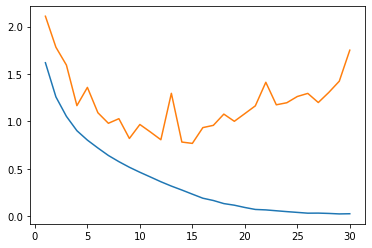

In [16]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'])
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'])
plt.show()

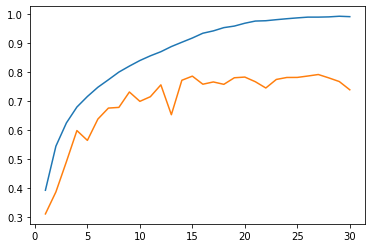

In [17]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'])
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'])
plt.show()